Sampling at 20kHz

Want to accurately capture signals as low as 20Hz

Input Size - 1024 Points



In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow.keras as keras
from keras.legacy import interfaces

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live
import tflite_runtime.interpreter as tflite

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 4)

from sklearn.metrics import confusion_matrix
import kerastuner as kt


from scipy.stats import probplot
from scipy.stats import normaltest


from scipy import signal

import os
import pandas as pd
from ML_Train.DBQuerier import DBQuerier as Querier
from sklearn.model_selection import train_test_split
from crawlab_toolbox import plotting as genplt


gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Using TensorFlow backend.


In [2]:
b,a = signal.butter(2, 700, btype='low', analog=False, output='ba', fs=20e3)

In [3]:
dataPoints = 4096
divisor = 4

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]


X_train_healthy = X_train[first_good_train:,:dataPoints]
X_valid_healthy = X_test[first_good_test:,:dataPoints]
X_train_unhealthy = X_train[:first_good_train,:dataPoints]
X_valid_unhealthy = X_test[:first_good_test,:dataPoints]

Y_train_healthy = Y_train[first_good_train:,:]
Y_valid_healthy = Y_test[first_good_test:,:]
Y_train_unhealthy = Y_train[:first_good_train,:]
Y_valid_unhealthy = Y_test[:first_good_test,:]

print(Y_train_unhealthy.shape)

X_train_healthy = X_train_healthy.reshape(X_train_healthy.shape[0] * 4,int(X_train_healthy.shape[1] / 4))
X_valid_healthy = X_valid_healthy.reshape(X_valid_healthy.shape[0] * 4,int(X_valid_healthy.shape[1] / 4))
X_train_unhealthy = X_train_unhealthy.reshape(X_train_unhealthy.shape[0] * 4,int(X_train_unhealthy.shape[1] / 4))
X_valid_unhealthy = X_valid_unhealthy.reshape(X_valid_unhealthy.shape[0] * 4,int(X_valid_unhealthy.shape[1] / 4))

X_train_healthy = (X_train_healthy + 2.5) / 5
X_valid_healthy = (X_valid_healthy + 2.5) / 5
X_train_unhealthy = (X_train_unhealthy + 2.5) / 5
X_valid_unhealthy = (X_valid_unhealthy + 2.5) / 5


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:-1]
Y_train = XY_train[:,-1]

X_valid = XY_valid[:,:-1]
Y_valid = XY_valid[:,-1]



(156, 2)


In [4]:
X_train.shape

(1224, 1024)

In [9]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   hp
                   ):
    inputs = Input(shape=(1024,1))
    x = inputs
    
    for i in range(hp.Int('filters', 2, 5, step=1)):
        x = Conv1D(filters=hp.Int('filters_' + str(i), 4, 64, step=4), 
                           kernel_size=hp.Int('kernels_' + str(i), 3, 19, step=4), 
                           strides=1, 
                           activation='relu', 
                           padding='same',
                           dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1))(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(hp.Int('dense_layers', 1, 3, step=1)):
        x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)

    x = Dense(2,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    cnn_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
     
    
    return cnn_classifier


In [10]:

tuner = kt.Hyperband(
    build_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    directory='cnn_vib_classifier',
    project_name='cnn_vib_classifier')

tuner.search(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 23s - loss: 0.8432 - accuracy: 0.562 - ETA: 2s - loss: 0.7283 - accuracy: 0.500 - ETA: 0s - loss: 0.7095 - accuracy: 0.49 - ETA: 0s - loss: 0.7010 - accuracy: 0.49 - ETA: 0s - loss: 0.6972 - accuracy: 0.49 - 1s 896us/sample - loss: 0.6922 - accuracy: 0.5016 - val_loss: 1.0676 - val_accuracy: 0.4305
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.68 - ETA: 0s - loss: 0.6592 - accuracy: 0.58 - ETA: 0s - loss: 0.6627 - accuracy: 0.55 - ETA: 0s - loss: 0.6697 - accuracy: 0.54 - ETA: 0s - loss: 0.6747 - accuracy: 0.54 - 0s 244us/sample - loss: 0.6729 - accuracy: 0.5482 - val_loss: 1.1746 - val_accuracy: 0.4305


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 16s - loss: 0.6342 - accuracy: 0.718 - ETA: 0s - loss: 0.9078 - accuracy: 0.495 - ETA: 0s - loss: 0.8130 - accuracy: 0.50 - 1s 639us/sample - loss: 0.7750 - accuracy: 0.5310 - val_loss: 0.7450 - val_accuracy: 0.4305
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.84 - ETA: 0s - loss: 0.5178 - accuracy: 0.76 - ETA: 0s - loss: 0.5117 - accuracy: 0.75 - 0s 166us/sample - loss: 0.5129 - accuracy: 0.7549 - val_loss: 1.7002 - val_accuracy: 0.4305


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 34s - loss: 1.2539 - accuracy: 0.468 - ETA: 3s - loss: 0.8905 - accuracy: 0.492 - ETA: 1s - loss: 0.8322 - accuracy: 0.51 - ETA: 0s - loss: 0.8140 - accuracy: 0.51 - ETA: 0s - loss: 0.7859 - accuracy: 0.52 - ETA: 0s - loss: 0.7620 - accuracy: 0.52 - 2s 1ms/sample - loss: 0.7504 - accuracy: 0.5392 - val_loss: 0.6893 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.59 - ETA: 0s - loss: 0.6502 - accuracy: 0.58 - ETA: 0s - loss: 0.6318 - accuracy: 0.63 - ETA: 0s - loss: 0.6220 - accuracy: 0.64 - ETA: 0s - loss: 0.6135 - accuracy: 0.65 - ETA: 0s - loss: 0.6063 - accuracy: 0.66 - 0s 287us/sample - loss: 0.5997 - accuracy: 0.6716 - val_loss: 0.7278 - val_accuracy: 0.4305


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 16s - loss: 0.8279 - accuracy: 0.531 - ETA: 1s - loss: 0.9742 - accuracy: 0.510 - ETA: 0s - loss: 0.8447 - accuracy: 0.51 - ETA: 0s - loss: 0.7974 - accuracy: 0.52 - 1s 688us/sample - loss: 0.7829 - accuracy: 0.5245 - val_loss: 0.6903 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.46 - ETA: 0s - loss: 0.6902 - accuracy: 0.53 - ETA: 0s - loss: 0.6793 - accuracy: 0.57 - ETA: 0s - loss: 0.6718 - accuracy: 0.58 - 0s 198us/sample - loss: 0.6759 - accuracy: 0.5882 - val_loss: 0.6835 - val_accuracy: 0.5695


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 16s - loss: 0.5638 - accuracy: 0.718 - ETA: 0s - loss: 0.7879 - accuracy: 0.557 - ETA: 0s - loss: 0.7906 - accuracy: 0.53 - ETA: 0s - loss: 0.7771 - accuracy: 0.53 - 1s 650us/sample - loss: 0.7761 - accuracy: 0.5368 - val_loss: 0.7013 - val_accuracy: 0.4305
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.68 - ETA: 0s - loss: 0.5545 - accuracy: 0.70 - ETA: 0s - loss: 0.5577 - accuracy: 0.70 - ETA: 0s - loss: 0.5635 - accuracy: 0.69 - 0s 175us/sample - loss: 0.5613 - accuracy: 0.6969 - val_loss: 0.6971 - val_accuracy: 0.4255


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 22s - loss: 1.0192 - accuracy: 0.437 - ETA: 1s - loss: 8.1190 - accuracy: 0.488 - ETA: 0s - loss: 4.7547 - accuracy: 0.51 - ETA: 0s - loss: 3.4761 - accuracy: 0.54 - 1s 849us/sample - loss: 2.9475 - accuracy: 0.5564 - val_loss: 2.4278 - val_accuracy: 0.4305
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.59 - ETA: 0s - loss: 0.6387 - accuracy: 0.68 - ETA: 0s - loss: 0.6157 - accuracy: 0.68 - ETA: 0s - loss: 0.6273 - accuracy: 0.68 - 0s 241us/sample - loss: 0.6099 - accuracy: 0.6928 - val_loss: 8.1004 - val_accuracy: 0.5695


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 17s - loss: 1.5240 - accuracy: 0.437 - ETA: 1s - loss: 0.8909 - accuracy: 0.502 - ETA: 0s - loss: 0.8093 - accuracy: 0.51 - 1s 668us/sample - loss: 0.7871 - accuracy: 0.5278 - val_loss: 0.6852 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.53 - ETA: 0s - loss: 0.6536 - accuracy: 0.60 - ETA: 0s - loss: 0.6540 - accuracy: 0.60 - ETA: 0s - loss: 0.6602 - accuracy: 0.59 - 0s 170us/sample - loss: 0.6610 - accuracy: 0.5980 - val_loss: 0.6950 - val_accuracy: 0.5695


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 35s - loss: 0.8334 - accuracy: 0.468 - ETA: 3s - loss: 0.9173 - accuracy: 0.539 - ETA: 1s - loss: 0.8782 - accuracy: 0.52 - ETA: 0s - loss: 0.8456 - accuracy: 0.53 - ETA: 0s - loss: 0.8233 - accuracy: 0.54 - ETA: 0s - loss: 0.8015 - accuracy: 0.54 - 2s 1ms/sample - loss: 0.7806 - accuracy: 0.5572 - val_loss: 0.6825 - val_accuracy: 0.6275
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.65 - ETA: 0s - loss: 0.6067 - accuracy: 0.66 - ETA: 0s - loss: 0.6234 - accuracy: 0.63 - ETA: 0s - loss: 0.6187 - accuracy: 0.65 - ETA: 0s - loss: 0.5885 - accuracy: 0.68 - ETA: 0s - loss: 0.5931 - accuracy: 0.67 - 0s 312us/sample - loss: 0.5935 - accuracy: 0.6724 - val_loss: 0.7510 - val_accuracy: 0.4305


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 35s - loss: 1.3556 - accuracy: 0.343 - ETA: 4s - loss: 1.0096 - accuracy: 0.442 - ETA: 2s - loss: 0.9175 - accuracy: 0.47 - ETA: 1s - loss: 0.8701 - accuracy: 0.48 - ETA: 0s - loss: 0.8407 - accuracy: 0.49 - ETA: 0s - loss: 0.8194 - accuracy: 0.50 - 2s 1ms/sample - loss: 0.8053 - accuracy: 0.5041 - val_loss: 0.6846 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.68 - ETA: 0s - loss: 0.6789 - accuracy: 0.58 - ETA: 0s - loss: 0.6884 - accuracy: 0.53 - ETA: 0s - loss: 0.6877 - accuracy: 0.55 - ETA: 0s - loss: 0.6927 - accuracy: 0.55 - ETA: 0s - loss: 0.6836 - accuracy: 0.56 - 0s 311us/sample - loss: 0.6858 - accuracy: 0.5727 - val_loss: 0.6879 - val_accuracy: 0.5695


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 22s - loss: 1.2419 - accuracy: 0.500 - ETA: 2s - loss: 1.3864 - accuracy: 0.510 - ETA: 0s - loss: 1.3430 - accuracy: 0.51 - ETA: 0s - loss: 1.3154 - accuracy: 0.50 - ETA: 0s - loss: 1.2063 - accuracy: 0.52 - 1s 877us/sample - loss: 1.1569 - accuracy: 0.5237 - val_loss: 0.7190 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.65 - ETA: 0s - loss: 0.6080 - accuracy: 0.68 - ETA: 0s - loss: 0.6114 - accuracy: 0.67 - ETA: 0s - loss: 0.6067 - accuracy: 0.68 - ETA: 0s - loss: 0.6022 - accuracy: 0.68 - 0s 267us/sample - loss: 0.5977 - accuracy: 0.6895 - val_loss: 0.6682 - val_accuracy: 0.5728


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 16s - loss: 0.7417 - accuracy: 0.468 - ETA: 0s - loss: 0.9090 - accuracy: 0.475 - ETA: 0s - loss: 0.8510 - accuracy: 0.47 - 1s 634us/sample - loss: 0.8046 - accuracy: 0.4984 - val_loss: 0.6970 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.68 - ETA: 0s - loss: 0.6266 - accuracy: 0.64 - ETA: 0s - loss: 0.6389 - accuracy: 0.64 - 0s 150us/sample - loss: 0.6373 - accuracy: 0.6454 - val_loss: 0.7661 - val_accuracy: 0.5695


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 31s - loss: 0.8077 - accuracy: 0.531 - ETA: 2s - loss: 0.8470 - accuracy: 0.468 - ETA: 0s - loss: 0.7859 - accuracy: 0.49 - ETA: 0s - loss: 0.7601 - accuracy: 0.49 - ETA: 0s - loss: 0.7463 - accuracy: 0.50 - 1s 1ms/sample - loss: 0.7465 - accuracy: 0.5033 - val_loss: 0.6852 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.46 - ETA: 0s - loss: 0.6859 - accuracy: 0.57 - ETA: 0s - loss: 0.6960 - accuracy: 0.54 - ETA: 0s - loss: 0.6934 - accuracy: 0.54 - ETA: 0s - loss: 0.6872 - accuracy: 0.55 - 0s 230us/sample - loss: 0.6875 - accuracy: 0.5539 - val_loss: 0.6918 - val_accuracy: 0.5695


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 31s - loss: 0.9703 - accuracy: 0.375 - ETA: 2s - loss: 1.7649 - accuracy: 0.486 - ETA: 1s - loss: 1.2937 - accuracy: 0.51 - ETA: 0s - loss: 1.0961 - accuracy: 0.54 - ETA: 0s - loss: 0.9703 - accuracy: 0.57 - 1s 1ms/sample - loss: 0.9260 - accuracy: 0.5850 - val_loss: 0.8930 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.87 - ETA: 0s - loss: 0.5968 - accuracy: 0.73 - ETA: 0s - loss: 0.5849 - accuracy: 0.73 - ETA: 0s - loss: 0.5574 - accuracy: 0.73 - ETA: 0s - loss: 0.5497 - accuracy: 0.74 - 0s 249us/sample - loss: 0.5286 - accuracy: 0.7533 - val_loss: 1.3210 - val_accuracy: 0.4305


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 21s - loss: 0.7671 - accuracy: 0.562 - ETA: 1s - loss: 0.7349 - accuracy: 0.550 - ETA: 0s - loss: 0.7481 - accuracy: 0.52 - ETA: 0s - loss: 0.7514 - accuracy: 0.50 - ETA: 0s - loss: 0.7455 - accuracy: 0.51 - 1s 799us/sample - loss: 0.7441 - accuracy: 0.5098 - val_loss: 0.7023 - val_accuracy: 0.4305
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.46 - ETA: 0s - loss: 0.6798 - accuracy: 0.54 - ETA: 0s - loss: 0.6582 - accuracy: 0.57 - ETA: 0s - loss: 0.6642 - accuracy: 0.57 - ETA: 0s - loss: 0.6708 - accuracy: 0.57 - 0s 224us/sample - loss: 0.6709 - accuracy: 0.5719 - val_loss: 0.6961 - val_accuracy: 0.4272


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 21s - loss: 1.9732 - accuracy: 0.406 - ETA: 1s - loss: 1.3188 - accuracy: 0.500 - ETA: 0s - loss: 1.0630 - accuracy: 0.51 - ETA: 0s - loss: 0.9637 - accuracy: 0.53 - 1s 817us/sample - loss: 0.9157 - accuracy: 0.5359 - val_loss: 2.2326 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.65 - ETA: 0s - loss: 0.5799 - accuracy: 0.69 - ETA: 0s - loss: 0.5602 - accuracy: 0.72 - ETA: 0s - loss: 0.5594 - accuracy: 0.73 - 0s 206us/sample - loss: 0.5415 - accuracy: 0.7394 - val_loss: 2.2054 - val_accuracy: 0.5695


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 29s - loss: 0.8168 - accuracy: 0.562 - ETA: 2s - loss: 0.9547 - accuracy: 0.500 - ETA: 1s - loss: 0.9401 - accuracy: 0.48 - ETA: 0s - loss: 0.9013 - accuracy: 0.49 - ETA: 0s - loss: 0.8670 - accuracy: 0.50 - 1s 1ms/sample - loss: 0.8556 - accuracy: 0.5082 - val_loss: 0.6945 - val_accuracy: 0.4288
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.46 - ETA: 0s - loss: 0.7303 - accuracy: 0.55 - ETA: 0s - loss: 0.7277 - accuracy: 0.54 - ETA: 0s - loss: 0.7134 - accuracy: 0.55 - ETA: 0s - loss: 0.7136 - accuracy: 0.55 - 0s 259us/sample - loss: 0.7129 - accuracy: 0.5539 - val_loss: 0.7412 - val_accuracy: 0.4305


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 15s - loss: 1.2532 - accuracy: 0.406 - ETA: 1s - loss: 1.0599 - accuracy: 0.512 - ETA: 0s - loss: 0.9564 - accuracy: 0.52 - ETA: 0s - loss: 0.9337 - accuracy: 0.53 - 1s 681us/sample - loss: 0.8872 - accuracy: 0.5466 - val_loss: 0.6812 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.96 - ETA: 0s - loss: 0.3463 - accuracy: 0.85 - ETA: 0s - loss: 0.3432 - accuracy: 0.85 - ETA: 0s - loss: 0.3378 - accuracy: 0.85 - 0s 213us/sample - loss: 0.3347 - accuracy: 0.8603 - val_loss: 0.7087 - val_accuracy: 0.4487


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 30s - loss: 1.3046 - accuracy: 0.343 - ETA: 2s - loss: 1.0350 - accuracy: 0.509 - ETA: 0s - loss: 0.9958 - accuracy: 0.52 - ETA: 0s - loss: 0.9793 - accuracy: 0.52 - ETA: 0s - loss: 0.9648 - accuracy: 0.50 - 1s 1ms/sample - loss: 0.9581 - accuracy: 0.5098 - val_loss: 0.6840 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.7847 - accuracy: 0.62 - ETA: 0s - loss: 0.7766 - accuracy: 0.57 - ETA: 0s - loss: 0.7757 - accuracy: 0.55 - ETA: 0s - loss: 0.7754 - accuracy: 0.56 - ETA: 0s - loss: 0.7802 - accuracy: 0.57 - 0s 237us/sample - loss: 0.7843 - accuracy: 0.5703 - val_loss: 0.7801 - val_accuracy: 0.4305


Train on 1224 samples, validate on 604 samples
Epoch 1/2
1224/1224 [==============================] - ETA: 27s - loss: 1.0648 - accuracy: 0.500 - ETA: 2s - loss: 1.0075 - accuracy: 0.518 - ETA: 0s - loss: 0.8913 - accuracy: 0.53 - ETA: 0s - loss: 0.8670 - accuracy: 0.53 - ETA: 0s - loss: 0.8476 - accuracy: 0.52 - 1s 989us/sample - loss: 0.8381 - accuracy: 0.5253 - val_loss: 0.9261 - val_accuracy: 0.5695
Epoch 2/2
1224/1224 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.59 - ETA: 0s - loss: 0.6838 - accuracy: 0.58 - ETA: 0s - loss: 0.6923 - accuracy: 0.57 - ETA: 0s - loss: 0.6666 - accuracy: 0.61 - ETA: 0s - loss: 0.6521 - accuracy: 0.63 - 0s 237us/sample - loss: 0.6435 - accuracy: 0.6373 - val_loss: 0.7186 - val_accuracy: 0.4338


Traceback (most recent call last):
  File "/home/dnewman/.local/lib/python3.6/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-cc156b995562>", line 33, in build_classifier
    x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 748, in __call__
    self._maybe_build(inputs)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 2116, in _maybe_build
    self.build(input_shapes)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py", line 1113, in build
    trainable=True)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 446, in add_weight
    caching_device=caching_device)
  File "/home/dnewman/.local/li

Traceback (most recent call last):
  File "/home/dnewman/.local/lib/python3.6/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-cc156b995562>", line 33, in build_classifier
    x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 748, in __call__
    self._maybe_build(inputs)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 2116, in _maybe_build
    self.build(input_shapes)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py", line 1113, in build
    trainable=True)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 446, in add_weight
    caching_device=caching_device)
  File "/home/dnewman/.local/li

Traceback (most recent call last):
  File "/home/dnewman/.local/lib/python3.6/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-cc156b995562>", line 33, in build_classifier
    x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 748, in __call__
    self._maybe_build(inputs)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 2116, in _maybe_build
    self.build(input_shapes)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py", line 1113, in build
    trainable=True)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 446, in add_weight
    caching_device=caching_device)
  File "/home/dnewman/.local/li

Traceback (most recent call last):
  File "/home/dnewman/.local/lib/python3.6/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-cc156b995562>", line 33, in build_classifier
    x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 748, in __call__
    self._maybe_build(inputs)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 2116, in _maybe_build
    self.build(input_shapes)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py", line 1113, in build
    trainable=True)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 446, in add_weight
    caching_device=caching_device)
  File "/home/dnewman/.local/li

Traceback (most recent call last):
  File "/home/dnewman/.local/lib/python3.6/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-cc156b995562>", line 33, in build_classifier
    x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 748, in __call__
    self._maybe_build(inputs)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 2116, in _maybe_build
    self.build(input_shapes)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py", line 1113, in build
    trainable=True)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 446, in add_weight
    caching_device=caching_device)
  File "/home/dnewman/.local/li

Traceback (most recent call last):
  File "/home/dnewman/.local/lib/python3.6/site-packages/kerastuner/engine/hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-9-cc156b995562>", line 33, in build_classifier
    x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='relu')(x)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 748, in __call__
    self._maybe_build(inputs)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 2116, in _maybe_build
    self.build(input_shapes)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/layers/core.py", line 1113, in build
    trainable=True)
  File "/home/dnewman/.local/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/base_layer.py", line 446, in add_weight
    caching_device=caching_device)
  File "/home/dnewman/.local/li

RuntimeError: Too many failed attempts to build model.

In [7]:
model = tuner.get_best_models(1)[0]


best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters

In [8]:
history = model.fit(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
                    epochs=30,
#                         validation_split=0.2,
                    verbose=1,
                  validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
                   )


Train on 1224 samples, validate on 604 samples
Epoch 1/30
1224/1224 [==============================] - ETA: 1:03 - loss: 0.4730 - accuracy: 0.78 - ETA: 6s - loss: 0.5970 - accuracy: 0.6953 - ETA: 2s - loss: 0.6021 - accuracy: 0.69 - ETA: 1s - loss: 0.5725 - accuracy: 0.71 - ETA: 0s - loss: 0.5630 - accuracy: 0.72 - 2s 2ms/sample - loss: 0.5637 - accuracy: 0.7181 - val_loss: 0.6028 - val_accuracy: 0.6672
Epoch 2/30
1224/1224 [==============================] - ETA: 0s - loss: 0.4607 - accuracy: 0.71 - ETA: 0s - loss: 0.5253 - accuracy: 0.74 - ETA: 0s - loss: 0.4949 - accuracy: 0.76 - ETA: 0s - loss: 0.4881 - accuracy: 0.76 - ETA: 0s - loss: 0.4856 - accuracy: 0.76 - 0s 245us/sample - loss: 0.4990 - accuracy: 0.7582 - val_loss: 0.8808 - val_accuracy: 0.4305
Epoch 3/30
1224/1224 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.75 - ETA: 0s - loss: 0.5219 - accuracy: 0.72 - ETA: 0s - loss: 0.5177 - accuracy: 0.73 - ETA: 0s - loss: 0.5054 - accuracy: 0.75 - ETA: 0s - l

In [53]:
Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])


In [54]:
Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)


conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[153 107]
 [ 86 258]]
0.6804635761589404
[[607  17]
 [ 79 521]]
0.9215686274509803


In [55]:
print(X_train_healthy.shape)
print(X_train_unhealthy.shape)

(600, 1024)
(624, 1024)


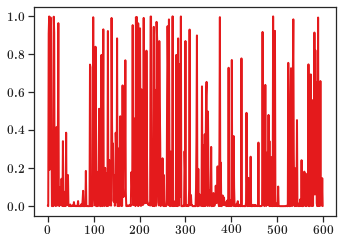

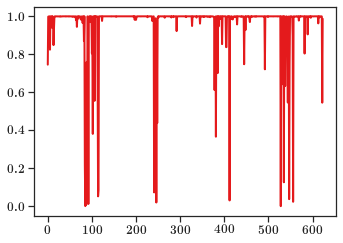

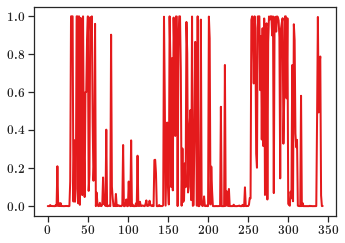

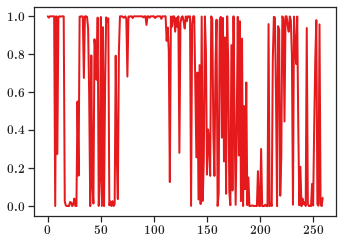

In [58]:
plt.plot(model.predict(X_train_healthy[...,np.newaxis])[:,0])
plt.show()

plt.plot(model.predict(X_train_unhealthy[...,np.newaxis])[:,0])
plt.show()

plt.plot(model.predict(X_valid_healthy[...,np.newaxis])[:,0])
plt.show()

plt.plot(model.predict(X_valid_unhealthy[...,np.newaxis])[:,0])
plt.show()